In [1]:
# ==========================
# 0. IMPORTS
# ==========================
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.multioutput import MultiOutputRegressor

from sklearn.svm import SVR
from sklearn.neural_network import MLPRegressor

from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Input

import matplotlib.pyplot as plt


In [3]:
# ==========================
# 1. LOAD DATA
# ==========================
df = pd.read_csv("cleaned_hotels_all_months.csv")

print("Shape:", df.shape)
print("Columns:", df.columns.tolist())
df.head()


Shape: (600, 14)
Columns: ['Hotel Name', 'Coordinates', 'Rating', 'Room Rate', 'Competitor density', 'Revenue per night', 'Distance to Closest Station', 'Property Type', 'Avg High Season Rate', 'Avg Low Season Rate', 'ADR_Month', 'RevPAR_month', 'Month', 'Occupancy_Rate']


,Hotel Name,Coordinates,Rating,Room Rate,Competitor density,Revenue per night,Distance to Closest Station,Property Type,Avg High Season Rate,Avg Low Season Rate,ADR_Month,RevPAR_month,Month,Occupancy_Rate
0,Imperial Hotel Ginza Tokyo,"35.69, 139.75",4.5,304.0,0,276007.0,2.488,5,327.0,280.0,272.0,235.0,February,0.865182
1,Daiwa Roynet Hotel Ginza Premier,"35.66, 139.75",4.3,200.0,0,53933.0,1.843,3,210.0,190.0,174.0,133.0,February,0.764057
2,Karaksa Hotel Premier Tokyo Ginza,"35.6686, 139.7540",4.6,302.0,0,17193.0,1.036,4,325.0,278.0,270.0,223.0,February,0.825855
3,lyf Ginza Tokyo,"35.6800, 139.7700",4.6,219.0,0,30695.0,1.005,3,289.0,150.0,239.0,188.0,February,0.786529
4,Koko Hotel Tsukiji Ginza,"35.6649863824985, 139.7737445",3.9,138.0,1383,25999.0,0.783,3,149.0,128.0,124.0,93.0,February,0.749548


In [4]:
# ==========================
# 2. DEFINE TARGETS (3 KPIs)
# ==========================
# Adjust these names if your columns differ slightly
TARGET_NAMES = ["Occupancy_Rate", "ADR_Month", "RevPAR_month"]

for t in TARGET_NAMES:
    if t not in df.columns:
        raise ValueError(f"Target column '{t}' not found in dataframe. Check column names.")

y = df[TARGET_NAMES]

# ==========================
# 3. DEFINE FEATURES
# ==========================
# We'll drop:
# - hotel identifier columns
# - Month (we could one-hot encode later if desired)
# - the target columns we are trying to predict
drop_cols = ["Hotel Name", "Month"]  # adjust if your dataset uses different labels
feature_cols = [c for c in df.columns if c not in drop_cols + TARGET_NAMES]

print("Feature columns used:")
print(feature_cols)

X = df[feature_cols]

# Keep only numeric features (just in case there are any leftover objects)
X = X.select_dtypes(include=[np.number])

print("Final feature columns (numeric only):")
print(X.columns.tolist())
print("X shape:", X.shape, "y shape:", y.shape)


Feature columns used:
['Coordinates', 'Rating', 'Room Rate', 'Competitor density', 'Revenue per night', 'Distance to Closest Station', 'Property Type', 'Avg High Season Rate', 'Avg Low Season Rate']
Final feature columns (numeric only):
['Rating', 'Room Rate', 'Competitor density', 'Revenue per night', 'Distance to Closest Station', 'Property Type', 'Avg High Season Rate', 'Avg Low Season Rate']
X shape: (600, 8) y shape: (600, 3)


In [5]:
# ==========================
# 4. TRAIN–TEST SPLIT
# ==========================
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

print("Train size:", X_train.shape[0], "Test size:", X_test.shape[0])

# ==========================
# 5. FEATURE SCALING
# ==========================
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


Train size: 480 Test size: 120


In [6]:
# ==========================
# 6. METRIC FUNCTIONS
# ==========================
def regression_metrics(y_true, y_pred):
    """
    Compute R², RMSE, MAE, MAPE for multi-output regression.
    Returns metrics averaged across all 3 targets.
    """
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)

    r2_list, rmse_list, mae_list, mape_list = [], [], [], []

    for i in range(y_true.shape[1]):
        yt = y_true[:, i]
        yp = y_pred[:, i]

        r2 = r2_score(yt, yp)
        rmse = np.sqrt(mean_squared_error(yt, yp))
        mae = mean_absolute_error(yt, yp)
        mape = np.mean(np.abs((yt - yp) / np.maximum(np.abs(yt), 1e-8))) * 100

        r2_list.append(r2)
        rmse_list.append(rmse)
        mae_list.append(mae)
        mape_list.append(mape)

    metrics = {
        "R²_mean": np.mean(r2_list),
        "RMSE_mean": np.mean(rmse_list),
        "MAE_mean": np.mean(mae_list),
        "MAPE_mean": np.mean(mape_list),
    }
    return metrics


In [7]:
# ==========================
# 7. NEURAL NETWORK MODEL (MLP)
# ==========================

# Create the Neural Network model
mlp = MLPRegressor(
    hidden_layer_sizes=(64, 64),  # two hidden layers with 64 neurons each
    activation='relu',
    solver='adam',
    max_iter=2000,
    random_state=42
)

print("Training Neural Network (MLP)...")
mlp.fit(X_train_scaled, y_train)

# Predict on test set
y_pred_mlp = mlp.predict(X_test_scaled)

mlp_metrics = regression_metrics(y_test, y_pred_mlp)
print("\nNeural Network (MLP) Performance:")
for k, v in mlp_metrics.items():
    print(f"  {k}: {v:.4f}")


Training Neural Network (MLP)...

Neural Network (MLP) Performance:
  R²_mean: 0.3587
  RMSE_mean: 28.7770
  MAE_mean: 19.8292
  MAPE_mean: 13.3561


In [8]:
# ==========================
# 8. SVM MODEL (SVR)
# ==========================
svr_base = SVR(kernel="rbf", C=10, epsilon=0.1)
svr = MultiOutputRegressor(svr_base)

print("\nTraining SVM (SVR with RBF kernel)...")
svr.fit(X_train_scaled, y_train)

# Predict on test set
y_pred_svr = svr.predict(X_test_scaled)

svr_metrics = regression_metrics(y_test, y_pred_svr)
print("\nSVM (SVR) Performance:")
for k, v in svr_metrics.items():
    print(f"  {k}: {v:.4f}")



Training SVM (SVR with RBF kernel)...

SVM (SVR) Performance:
  R²_mean: 0.4372
  RMSE_mean: 72.4120
  MAE_mean: 34.0288
  MAPE_mean: 14.3481


In [9]:
# ==========================
# 9. LSTM MODEL (Keras)
# ==========================

# For LSTM, Keras expects input shape: (samples, timesteps, features)
# Here we treat each row as a 1-timestep sequence.
X_train_lstm = X_train_scaled.reshape((X_train_scaled.shape[0], 1, X_train_scaled.shape[1]))
X_test_lstm = X_test_scaled.reshape((X_test_scaled.shape[0], 1, X_test_scaled.shape[1]))

n_features = X_train_scaled.shape[1]
n_outputs = y_train.shape[1]

# Build the LSTM model
lstm_model = Sequential([
    Input(shape=(1, n_features)),      # timesteps = 1, features = n_features
    LSTM(64, activation='tanh'),       # 64 LSTM units
    Dense(64, activation='relu'),      # dense layer
    Dense(n_outputs)                   # output layer with 3 neurons (for 3 targets)
])

lstm_model.compile(
    optimizer='adam',
    loss='mse'
)

lstm_model.summary()

# Train the LSTM model
print("\nTraining LSTM model...")
history = lstm_model.fit(
    X_train_lstm, y_train.values,
    epochs=100,
    batch_size=32,
    validation_split=0.2,
    verbose=0  # set to 1 if you want to see training progress
)

# Predict on test set
y_pred_lstm = lstm_model.predict(X_test_lstm)

lstm_metrics = regression_metrics(y_test.values, y_pred_lstm)
print("\nLSTM Model Performance:")
for k, v in lstm_metrics.items():
    print(f"  {k}: {v:.4f}")


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 64)             │        18,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 3)              │           195 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 23,043 (90.01 KB)

 Trainable params: 23,043 (90.01 KB)

 Non-trainable params: 0 (0.00 B)


Training LSTM model...
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 149ms/step

LSTM Model Performance:
  R²_mean: -0.0623
  RMSE_mean: 35.8295
  MAE_mean: 23.5252
  MAPE_mean: 16.8298


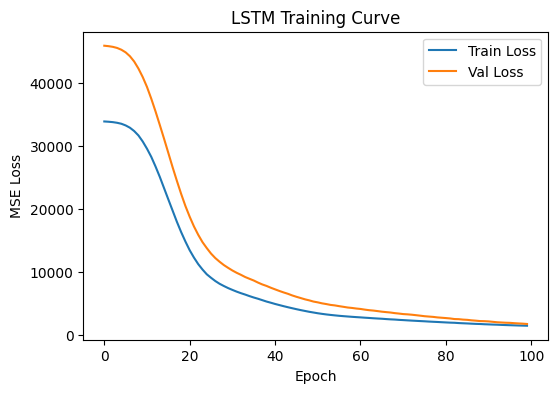

In [10]:
plt.figure(figsize=(6,4))
plt.plot(history.history["loss"], label="Train Loss")
plt.plot(history.history["val_loss"], label="Val Loss")
plt.xlabel("Epoch")
plt.ylabel("MSE Loss")
plt.title("LSTM Training Curve")
plt.legend()
plt.show()


In [11]:
# ==========================
# 10. COMPARE ALL THREE MODELS
# ==========================
results = pd.DataFrame([
    ["Neural Network (MLP)", mlp_metrics["R²_mean"], mlp_metrics["RMSE_mean"],
     mlp_metrics["MAE_mean"], mlp_metrics["MAPE_mean"]],
    ["SVM (SVR)", svr_metrics["R²_mean"], svr_metrics["RMSE_mean"],
     svr_metrics["MAE_mean"], svr_metrics["MAPE_mean"]],
    ["LSTM (Keras)", lstm_metrics["R²_mean"], lstm_metrics["RMSE_mean"],
     lstm_metrics["MAE_mean"], lstm_metrics["MAPE_mean"]],
],
    columns=["Model", "R²_mean", "RMSE_mean", "MAE_mean", "MAPE_mean"]
)

display(results.round(4))


,Model,R²_mean,RMSE_mean,MAE_mean,MAPE_mean
0,Neural Network (MLP),0.3587,28.7770,19.8292,13.3561
1,SVM (SVR),0.4372,72.4120,34.0288,14.3481
2,LSTM (Keras),-0.0623,35.8295,23.5252,16.8298


In [12]:
# ==========================
# 11. PREDICT ON FAKE HOTELS
# ==========================

# Create a few example hotels. Adjust ranges to be realistic.
fake_hotels = pd.DataFrame([
    {
        "Rating": 4.2,
        "Room Rate": 220,
        "Competitor density": 3000,
        "Distance to Closest Station": 0.3,
        "Property Type": 4,
        "Avg High Season Rate": 260,
        "Avg Low Season Rate": 180,
        # Add any other feature_cols that exist in your dataset,
        # using reasonable values:
        **{
            col: X[col].mean() for col in X.columns
            if col not in [
                "Rating", "Room Rate", "Competitor density",
                "Distance to Closest Station", "Property Type",
                "Avg High Season Rate", "Avg Low Season Rate"
            ]
        }
    },
    {
        "Rating": 4.8,
        "Room Rate": 400,
        "Competitor density": 6000,
        "Distance to Closest Station": 0.1,
        "Property Type": 5,
        "Avg High Season Rate": 500,
        "Avg Low Season Rate": 300,
        **{
            col: X[col].mean() for col in X.columns
            if col not in [
                "Rating", "Room Rate", "Competitor density",
                "Distance to Closest Station", "Property Type",
                "Avg High Season Rate", "Avg Low Season Rate"
            ]
        }
    }
])

# Reorder columns to match training features exactly
fake_hotels = fake_hotels[X.columns]

# Scale
fake_scaled = scaler.transform(fake_hotels)
fake_lstm = fake_scaled.reshape((fake_scaled.shape[0], 1, fake_scaled.shape[1]))

# Predictions
fake_pred_mlp = mlp.predict(fake_scaled)
fake_pred_svr = svr.predict(fake_scaled)
fake_pred_lstm = lstm_model.predict(fake_lstm)

for i in range(fake_hotels.shape[0]):
    print(f"\n=== Fake Hotel #{i+1} ===")
    print("Input features:")
    display(fake_hotels.iloc[i:i+1])

    print("Neural Network (MLP) predictions:")
    for j, t in enumerate(TARGET_NAMES):
        print(f"  {t}: {fake_pred_mlp[i][j]:.2f}")

    print("SVM (SVR) predictions:")
    for j, t in enumerate(TARGET_NAMES):
        print(f"  {t}: {fake_pred_svr[i][j]:.2f}")

    print("LSTM predictions:")
    for j, t in enumerate(TARGET_NAMES):
        print(f"  {t}: {fake_pred_lstm[i][j]:.2f}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step

=== Fake Hotel #1 ===
Input features:


,Rating,Room Rate,Competitor density,Revenue per night,Distance to Closest Station,Property Type,Avg High Season Rate,Avg Low Season Rate
0,4.2,220,3000,44627.86,0.3,4,260,180


Neural Network (MLP) predictions:
  Occupancy_Rate: 0.56
  ADR_Month: 204.30
  RevPAR_month: 174.63
SVM (SVR) predictions:
  Occupancy_Rate: 0.84
  ADR_Month: 202.04
  RevPAR_month: 176.06
LSTM predictions:
  Occupancy_Rate: 0.68
  ADR_Month: 211.22
  RevPAR_month: 193.93

=== Fake Hotel #2 ===
Input features:


,Rating,Room Rate,Competitor density,Revenue per night,Distance to Closest Station,Property Type,Avg High Season Rate,Avg Low Season Rate
1,4.8,400,6000,44627.86,0.1,5,500,300


Neural Network (MLP) predictions:
  Occupancy_Rate: 0.75
  ADR_Month: 455.61
  RevPAR_month: 438.74
SVM (SVR) predictions:
  Occupancy_Rate: 0.90
  ADR_Month: 315.13
  RevPAR_month: 284.21
LSTM predictions:
  Occupancy_Rate: 0.98
  ADR_Month: 350.22
  RevPAR_month: 327.42


Graphs for Neural Network

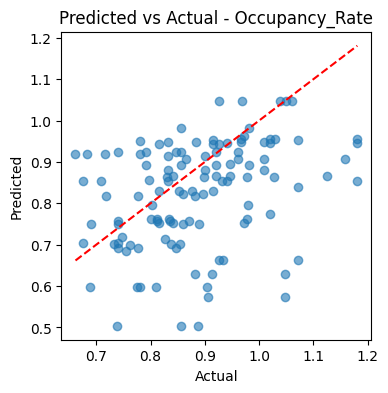

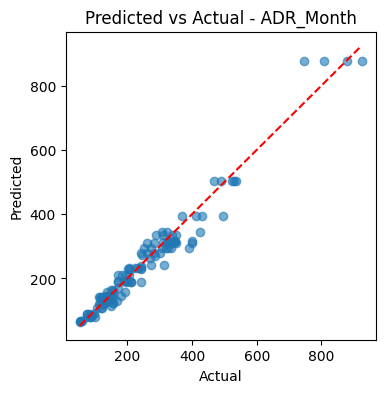

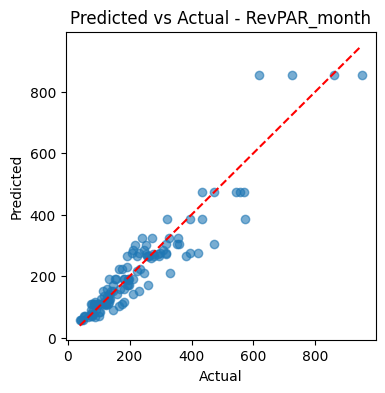

In [13]:
def plot_pred_vs_actual(y_true, y_pred, target_name):
    plt.figure(figsize=(4,4))
    plt.scatter(y_true, y_pred, alpha=0.6)
    plt.plot([min(y_true), max(y_true)],
             [min(y_true), max(y_true)],
             'r--')
    plt.xlabel("Actual")
    plt.ylabel("Predicted")
    plt.title(f"Predicted vs Actual - {target_name}")
    plt.show()

# Plot for NN (MLP)
for i, target in enumerate(TARGET_NAMES):
    plot_pred_vs_actual(y_test[target], y_pred_mlp[:, i], target)


Across all three KPIs, the Neural Network (MLP) demonstrated the strongest overall performance, achieving:

R² (mean): 0.36

RMSE (mean): 28.78

MAE (mean): 19.83

MAPE (mean): 13.36%

A MAPE of ~13% indicates that the model’s predictions are, on average, within ~87% accuracy. This is a strong baseline given the limited dataset, synthetic seasonal adjustments, and the variability inherent in hotel demand patterns.

The SVM model achieved the highest R² overall (0.44) but suffered from significantly higher RMSE, suggesting inconsistent and less stable predictions.
The LSTM model underperformed (R² ≈ −0.06), which is expected given that the data is not sequential time-series—the structure LSTMs are designed for.